# Analysis

In [48]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [49]:
sns.set(rc={'figure.figsize':(16,9)}, font_scale=1.7)
plt.style.use('seaborn-whitegrid')

In [108]:
year = 'model_old_v7'#'model_new_v6'

### Systematic errors?

просто флаг, чтоб отдельно сохранять результат

In [109]:
sys_err = False

## Data preparation


Пример с `open`
```python
f = uproot.open("../outputs/19/trees/550.00_70260.root")
f['t'].pandas.df()
```

In [110]:
f = uproot.pandas.iterate("../outputs/"+year+"/trees/*_*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure'])

In [111]:
dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])

In [112]:
dataRAW.shape

(70710, 5)

In [113]:
dataRAW.sort_values(by='name', ascending=True, inplace=True);

Количество уникальных `name` в `data` должно совпадать с количеством точек в сезоне

* 11 год: 40 точек
* 12 год: 16 точек
* 17 год: 34 точки
* 19 год: 44 точки
* моделирование: 38 точек

In [114]:
print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')

Checking: 39 different names in model_old_v7 season


Проверка типов полей датафрейма

In [115]:
dataRAW.dtypes

beam_energy    float64
mass           float64
trigger          int32
procedure        int32
name           float64
dtype: object

Проверка данных

In [116]:
dataRAW.describe()

,beam_energy,mass,trigger,procedure,name
count,70710.000000,70710.000000,70710.000000,70710.000000,70710.000000
mean,771.771183,489.062230,1.648706,2.268335,771.771182
std,139.976020,67.430001,0.772370,0.495844,139.976021
min,508.600006,-1.000000,-1.000000,1.000000,508.600000
25%,650.000000,492.693428,2.000000,2.000000,650.000000
50%,812.500000,497.739792,2.000000,2.000000,812.500000
75%,875.000000,502.789093,2.000000,3.000000,875.000000
max,1000.000000,577.296082,2.000000,3.000000,1000.000000


Проверить триггер

In [117]:
bad_trig = dataRAW.query('trigger<0')
print('Energy points with bad trigger:\n', bad_trig.name.value_counts())

Energy points with bad trigger:
 508.6     180
550.0      63
562.5      50
825.0      40
587.5      33
612.5      30
575.0      28
625.0      25
875.0      24
862.5      22
837.5      22
850.0      21
600.0      18
762.5      15
650.0      14
787.5      14
812.5      14
925.0      13
912.5      13
662.5      12
887.5      12
900.0      11
800.0      11
775.0      11
637.5      10
700.0      10
962.5       9
687.5       9
675.0       8
750.0       8
950.0       8
945.0       7
935.0       7
975.0       6
712.5       6
725.0       6
737.5       6
1000.0      5
987.5       5
Name: name, dtype: int64


Проверить энергии

In [118]:
bad_en = dataRAW.query('beam_energy<0')
print('Bad energy records:', bad_en.name.shape[0])

Bad energy records: 0


Удалить события с плохим триггером и энергиями (не в моделировании)

In [119]:
data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')

Оставить только массы внутри окна (450,550) и без процедуры kinfit

In [120]:
data = data.query('mass>450&mass<550&procedure!=1')

In [121]:
print(data.shape[0], 'records left')

68680 records left


Удалить ненужные столбцы

In [122]:
data.drop(['procedure'], axis=1, inplace=True)

/store17/petrov/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [123]:
data.head()

,beam_energy,mass,trigger,name
4404,508.600006,485.541443,2,508.6
4147,508.600006,500.935883,2,508.6
4146,508.600006,494.614441,2,508.6
4145,508.600006,498.278503,2,508.6
4144,508.600006,494.296295,2,508.6


Добавить светимости

In [136]:
lum = pd.read_csv(f'../inputs/{year}/lum.dat')
lum.rename({'label': 'name'}, axis=1, inplace=True)
if 'err' in lum.columns:
    lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    
lum = lum.sort_values(by='name').drop_duplicates(subset=['name'])

In [137]:
lum.tail()

,name,lum
33,950.0,5294
34,962.5,4667
35,975.0,4112
36,987.5,3640
37,1000.0,3361


Проверить данные (хорошо, если числа совпадают)

Если не совпадают, то проверить светимости на дубликаты или проверить названия файлов, возможно их нужно вручную исправить

In [138]:
print('Records in  lum:', lum.shape[0])
print('Records in data:', data.name.unique().shape[0])

Records in  lum: 39
Records in data: 39


Объединить данные и светимость

In [139]:
data_prep = lum.merge(data, on='name')

In [140]:
def check_foo(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return

In [141]:
check_foo(data_prep, data)

Good. 68680 rows


Смотрим, в каких именно точках не совпадают `data` и `lum`

In [142]:
set1 = set(data.name.unique())
set2 = set(lum.name.unique())

(set1|set2).difference(set1&set2)

set()

### Pictures

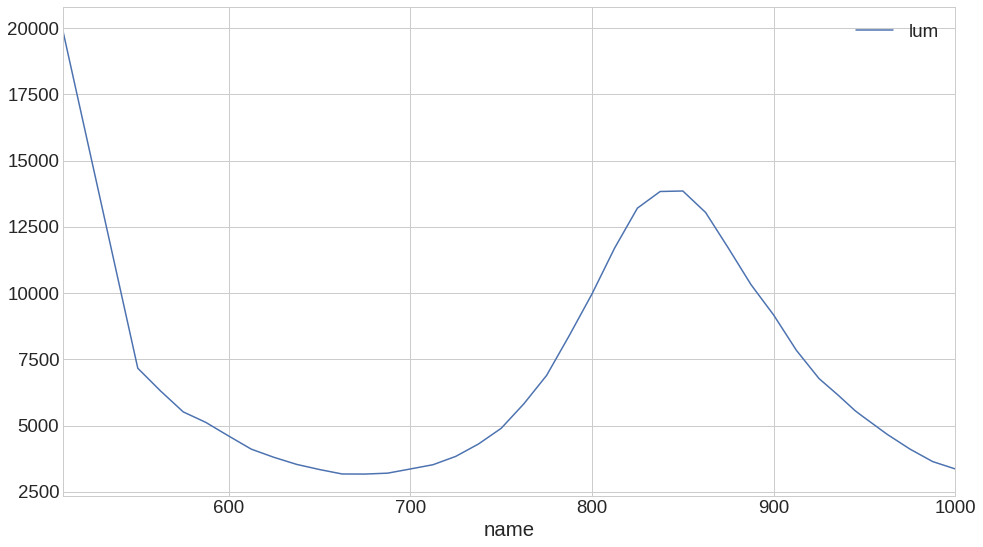

In [143]:
lum.plot(x='name', y='lum')

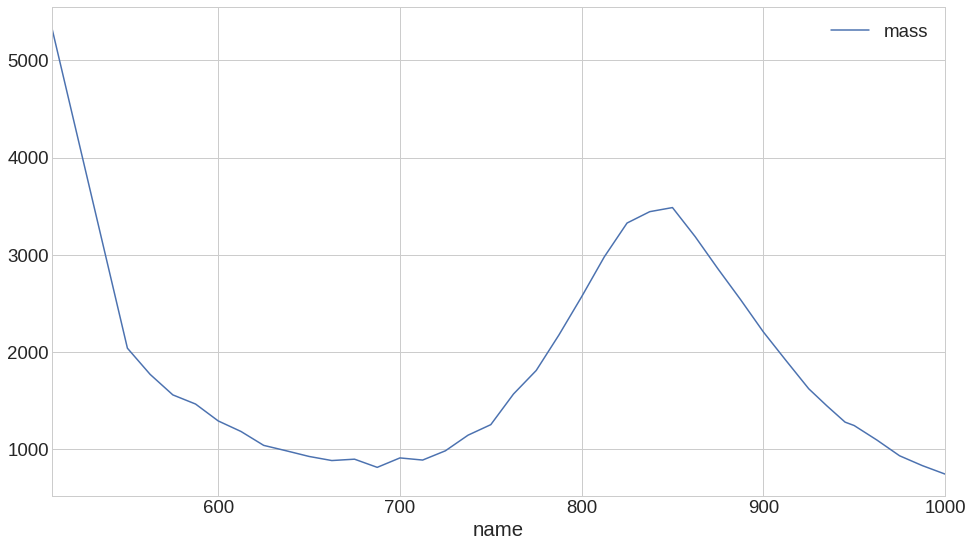

In [144]:
data_prep.groupby('name').agg({'mass':np.size}).plot()

In [145]:
data_prep.groupby('name').agg({'mass':np.size})

,mass
name,
508.6,5320.0
550.0,2041.0
562.5,1772.0
575.0,1561.0
587.5,1467.0
600.0,1293.0
612.5,1185.0
625.0,1042.0
637.5,986.0


Слияние точек

In [146]:
cnct = []
if year=='11':
    cnct = [([887.5, 900., 912.5, 925., 935.], 910), ([945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year
if year=='12':
    cnct = [([900., 920., 936.], 920), ([950., 960., 970.,], 950), ([ 980., 990], 960)] #12 year
if year=='17':
    cnct = [([880., 890.], 885), ([900., 910.], 905), ([920., 930.], 925),
           ([937.4, 937.5, 938.3, 938.9, 939.6, 940.2, 940.8], 939)] #17 year
#     cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935),
#             ([937.4, 938.3, 938.9], 938), ([939.6, 940.2, 940.8], 940),
#             ([942., 950., 960., 971.], 960), ([981., 990, 1003.5],990)] #17 year
# if year=='19': #в последний раз не сливал точки
#     cnct = [([862.5, 875.0, 887.5, 900.0, 912.5, 925], 875),([936, 945.0, 950.0, 951.1, 955.0, 962.5], 955),
#             ([975., 978.0, 987.5], 980)] #19year

In [147]:
for c in cnct:
    data_prep.name.replace(c[0], c[1], inplace=True)

OK, points have been merged

In [148]:
data_prep.tail()

,name,lum,beam_energy,mass,trigger
68675,1000.0,3361,1000.0,493.645874,2
68676,1000.0,3361,1000.0,515.456543,2
68677,1000.0,3361,1000.0,503.058228,2
68678,1000.0,3361,1000.0,495.890411,2
68679,1000.0,3361,1000.0,496.942139,2


In [149]:
check_foo(data_prep, data)

Good. 68680 rows


### Пересчитать светимости в слитых точках

In [150]:
data_prep['lume'] = data_prep.beam_energy*data_prep.lum

Проверить правильность слияния

In [151]:
#число в поле lum с количеством элементов в списке для слияния
data_prep[['lum', 'name']].\
drop_duplicates(subset=['name','lum']).groupby('name').agg({'lum':np.size}).query('lum!=1')

,lum
name,


In [152]:
new_lum = data_prep[['beam_energy', 'lum', 'lume', 'name']].drop_duplicates(subset=['lum','name']).\
groupby('name').agg({'lume':[np.sum], 'lum':[np.sum], 'beam_energy':[np.min, np.max]})

In [153]:
new_lum.shape

(39, 4)

In [154]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [155]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [156]:
#data.loc[641.].beam_energy.std()

In [157]:
new_lum.query('dEmin>0')

,lum,dEmin,dEmax,Emean
name,,,,


I have got new luminosity table.

Now I should join it to existing table

In [158]:
data_prep.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)

In [159]:
final_data = data_prep.join(new_lum, how='inner', on='name')

In [160]:
check_foo(final_data, data_prep)

Good. 68680 rows


That is good. Now I should do the analysis

In [161]:
final_data.tail()

,name,mass,trigger,lum,dEmin,dEmax,Emean
68675,1000.0,493.645874,2,3361,0.0,0.0,1000.0
68676,1000.0,515.456543,2,3361,0.0,0.0,1000.0
68677,1000.0,503.058228,2,3361,0.0,0.0,1000.0
68678,1000.0,495.890411,2,3361,0.0,0.0,1000.0
68679,1000.0,496.942139,2,3361,0.0,0.0,1000.0


----------------
## Fit

In [162]:
data2 = final_data.groupby('name')

In [163]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

508.6
550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
887.5
900.0
912.5
925.0
935.0
945.0
950.0
962.5
975.0
987.5
1000.0


In [164]:
import iminuit
import probfit as pf

In [165]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})

In [166]:
mass_bound = (450, 550)

In [167]:
#гаусс + const
def constant(x):
    return 1
def gauss(x, mu, sigma):
    return pf.gaussian(x, mu, sigma)

norm_sig = pf.rename( pf.Normalized( gauss, mass_bound ), ['x', 'M', '$\\sigma$'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

MLim = (497.6, 7.0)
sigmaLim = (6.60, 6.0)

limits = {
    "limit_M": [MLim[0]-MLim[1], MLim[0]+MLim[1]],
    "limit_$\\sigma$": [sigmaLim[0] - sigmaLim[1], sigmaLim[0] + sigmaLim[1]],
    "limit_$N_{sig}$": [0, 100000],
    "limit_$N_{bkg}$": [0, 2000],
}
errors = {
    "error_M": 1,
    "error_$\\sigma$": 0.1,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
}

pf.describe(pdf)

['x', 'M', '$\\sigma$', '$N_{sig}$', '$N_{bkg}$']

In [168]:
def fitter(dic, nbins, energy, binnedLik=False, simple_plot=True):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M": 497.6, "$\sigma$": 4.26, "$N_{sig}$": np.size(dic), "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    if simple_plot:
        likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    else:
        fig = plt.figure(figsize=(16, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

        # Define the axes
        ax_main = fig.add_subplot(grid[:-1, :])
        ax_main.grid(ls=':')
        box_1 = {'facecolor':'black', 'boxstyle': 'round'}

        if binnedLik:
            likelihood.draw(minuit=mt, print_par=True);
        else:
            likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound, print_par=True)

        plt.tick_params(labelsize=20);
        plt.xlabel('invariant mass, MeV', fontsize=20)
        plt.ylabel('number of events per bin', fontsize=20)

        # this is an inset axes over the main axes
        ax_bottom = fig.add_subplot(grid[-1, :], xticklabels=[])
        ax_bottom.grid(ls=':')
        likelihood.draw_residual(minuit=mt) if binnedLik else \
        likelihood.draw_residual(minuit=mt, bins=nbins, bound=mass_bound)
    
        plt.savefig(f'./Journal/outputs/images/19_1.1GeV.png', dpi=300)
    return mt, likelihood

In [169]:
itr = iter(dic)

In [170]:
fit_frame = pd.DataFrame(columns=[ 'M', 'Sigma', 'Nsig', 'Nbkg', 
                                  'Merr', 'Serr', 'Nsig_err', 'Nbkg_err'])

In [172]:
i = next(itr)
print('Label:', i)

Label: 550.0


Migrad quality: True
Real: 2041 Found: 2040.9210516990493


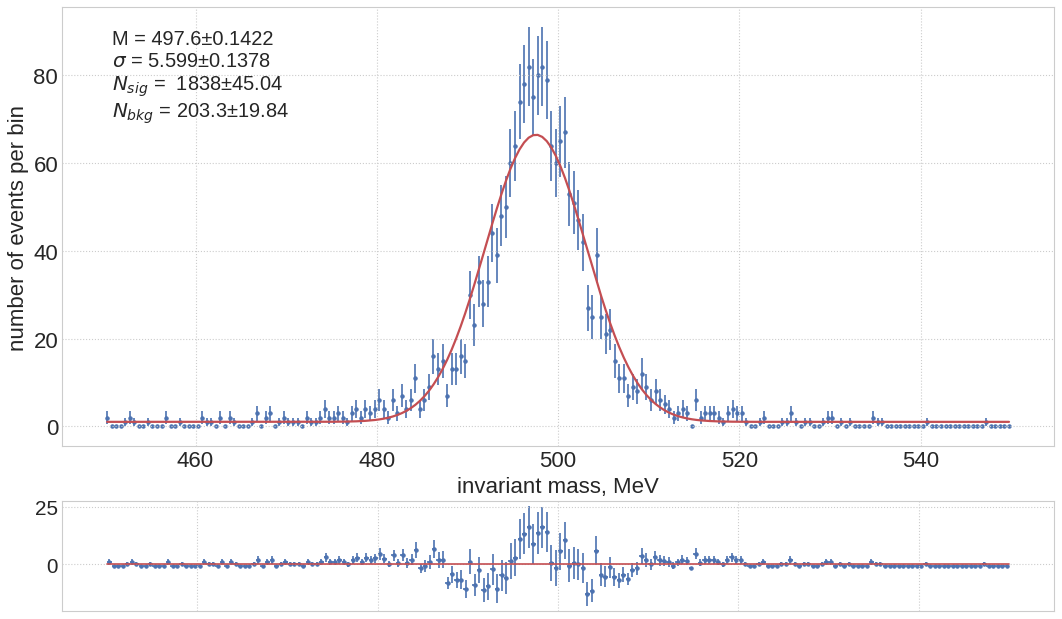

In [173]:
dicx = dic[i]
# dicx = np.hstack((dic[925],dic[936],dic[939]))
mt, lik = fitter(dicx, 200, i, False, False)
fit_frame.loc[i] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['$N_{sig}$'] + mt.values['$N_{bkg}$'] )

In [182]:
fit_frame.tail(20)

,M,Sigma,Nsig,Nbkg,Merr,Serr,Nsig_err,Nbkg_err
775.0,497.986504,7.874892,2107.723838,118.300221,0.183586,0.184363,48.696158,19.535575
787.5,497.689278,7.803182,2199.055154,128.027037,0.177235,0.162017,49.101870,18.432421
800.0,497.831717,8.074636,2332.904229,120.187918,0.177819,0.166666,50.810851,19.204493
812.5,498.040382,8.110283,2312.795324,117.260935,0.179197,0.166396,50.473891,18.758352
825.0,497.840858,7.860371,2104.301563,156.656679,0.184158,0.171160,48.477839,20.057194
837.5,497.769686,8.437739,1897.344119,104.874997,0.207172,0.200935,46.134759,18.319719
850.0,498.038293,8.425850,1414.672874,88.320298,0.240011,0.229507,39.969003,16.462644
862.5,498.489050,8.324489,1008.476843,61.527932,0.278839,0.247159,33.243678,12.574359
875.0,498.823919,7.463962,634.564049,66.357743,0.320896,0.284491,26.643701,11.901477
887.5,499.711320,8.610004,436.532811,37.419094,0.450565,0.426943,22.409402,10.154270


# Save fit info

In [186]:
fit_frame.to_csv(f'../outputs/{year}/tables/fit_frame{"_sys" if sys_err else ""}.csv')

In [191]:
# mt.matrix(correlation=True)
# mt.draw_profile('$N_{sig}$');

In [192]:
dataN = fit_frame[['Nsig','Nsig_err']]
dataN.columns = ['Nsig', 'dNsig']
dataN.index.names = ['name']

In [193]:
dataN.tail()

,Nsig,dNsig
name,,
950.0,200.053961,15.376006
962.5,203.820671,15.934437
975.0,235.103541,15.990253
987.5,248.129750,17.108580
1000.0,258.561498,17.468048


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [194]:
data_info = final_data.drop_duplicates(['name','lum']).drop(['mass', 'trigger'], axis=1).set_index('name')

In [195]:
dataN = data_info.join(dataN, how='inner')
dataN

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
525.0,11111,0.0,0.0,525.0,2542.468873,52.067535
537.5,9297,0.0,0.0,537.5,2322.680686,50.027507
550.0,8283,0.0,0.0,550.0,2102.946901,47.566615
562.5,7657,0.0,0.0,562.5,1859.829664,45.674997
575.0,7106,0.0,0.0,575.0,1805.893940,44.119437
587.5,6666,0.0,0.0,587.5,1700.710808,42.695274
600.0,6369,0.0,0.0,600.0,1622.697939,41.597451
612.5,5887,0.0,0.0,612.5,1455.737847,40.096875
625.0,5579,0.0,0.0,625.0,1393.103518,39.042687


In [196]:
check_foo(dataN, fit_frame)

Good. 40 rows


OK, save it

In [197]:
dataN.to_csv(f'../outputs/{year}/tables/signal_table{year}{"_sys" if sys_err else ""}.csv', float_format='%.4f')

Ok, now about triggers

In [135]:
triggers = final_data[['trigger','name']].set_index('name')
triggers = triggers.assign(one = 1);

In [136]:
triggers

,trigger,one
name,,
641.0,0,1
641.0,2,1
641.0,2,1
641.0,2,1
641.0,2,1
...,...,...
1003.5,2,1
1003.5,2,1
1003.5,0,1


In [137]:
check_foo(triggers, final_data)

Good. 1888 rows


In [138]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)

In [139]:
triggers.columns = ['TF', 'CF', 'TC']

In [140]:
triggers.head()

,TF,CF,TC
name,,,
641.0,94.0,4.0,275.0
650.0,15.0,1.0,91.0
675.0,29.0,1.0,65.0
700.0,15.0,0.0,33.0
725.0,17.0,1.0,52.0


In [141]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [142]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [143]:
check_foo(triggers, dataN)

Good. 25 rows


In [144]:
triggers.head()

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
641.0,94.0,4.0,275.0,0.982206,0.743935,0.995444,0.007872,0.022629,0.002056
650.0,15.0,1.0,91.0,0.978723,0.851852,0.996848,0.014805,0.034026,0.002310
675.0,29.0,1.0,65.0,0.970588,0.687500,0.990809,0.020340,0.047063,0.006505
700.0,15.0,0.0,33.0,0.971429,0.680000,0.990857,0.027766,0.065320,0.009079
725.0,17.0,1.0,52.0,0.963636,0.746479,0.990781,0.025015,0.051268,0.006610


In [145]:
triggers.to_csv(f'../outputs/{year}/tables/triggers{year}{"_sys" if sys_err else ""}.csv', float_format='%.4f')

### Check triggers

In [146]:
trig_data = pd.read_csv(f'../outputs/{year}/tables/triggers{year}.csv')

In [147]:
trig_data.head()

,name,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
0,641.0,94.0,4.0,275.0,0.9822,0.7439,0.9954,0.0079,0.0226,0.0021
1,650.0,15.0,1.0,91.0,0.9787,0.8519,0.9968,0.0148,0.0340,0.0023
2,675.0,29.0,1.0,65.0,0.9706,0.6875,0.9908,0.0203,0.0471,0.0065
3,700.0,15.0,0.0,33.0,0.9714,0.6800,0.9909,0.0278,0.0653,0.0091
4,725.0,17.0,1.0,52.0,0.9636,0.7465,0.9908,0.0250,0.0513,0.0066


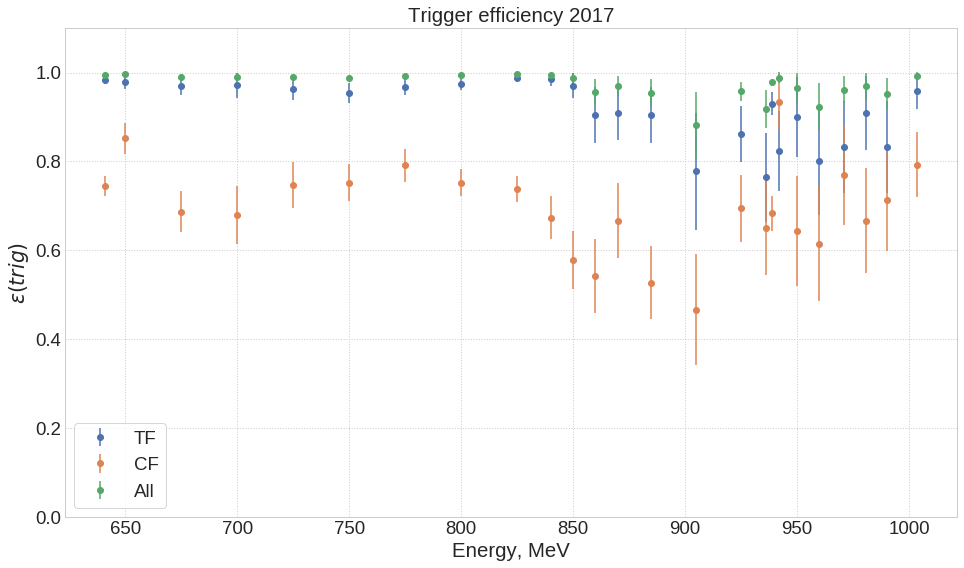

In [148]:
plt.errorbar(data=trig_data, x='name', y='eTF', yerr='vTF', fmt='o', label='TF')
plt.errorbar(data=trig_data, x='name', y='eCF', yerr='vCF', fmt='o', label='CF');
plt.errorbar(data=trig_data, x='name', y='TrigEff', yerr='TrigErr', fmt='o', label='All');
plt.grid(linestyle=':')
plt.ylim(0, 1.1)
plt.title(f'Trigger efficiency 20{year}');
plt.xlabel('Energy, MeV');
plt.ylabel('$\\varepsilon(trig)$')
plt.legend(frameon=True)